In [1]:
#%%


import logging
import copy
from pathlib import Path
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import dateparser
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor



import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger



import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import optim


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#%%


akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")
futures_client = Client(key = akey, secret= asec)

#%%

#DATA PARAMETERS

PREFIX = os.getcwd()
BLOCK = 512
DUMP = '.csv'
DATA_DIR = os.path.join(PREFIX, "datasets")

#%%

TIMEFRAME = "15m"
PAIR = "ETHUSDT"
# FROM_DATE = "2022-01-14 01:00:00" 
# TO_DATE = "2022-10-05 01:00:00"
FROM_DATE = "2022-06-01" 
TO_DATE = "2022-10-17"
NUM_DATA = 1000 #max 100k idk why

#%%

###

#PARAMETERS

DATA_WINDOW_LENGTH = BLOCK
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10

###

dir_name = f"{NUM_DATA}_{PAIR}_{TIMEFRAME}_{FROM_DATE.replace(' ', '-').replace(':', '')}_{TO_DATE.replace(' ', '-').replace(':', '')}"

NEW_DATA_DIR = os.path.join(PREFIX, DATA_DIR, dir_name)

if not os.path.exists(NEW_DATA_DIR):
    os.makedirs(NEW_DATA_DIR)
print(NEW_DATA_DIR)    


import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt



/home/istrozzi/.cloned/trailing_orders/DEV/datasets/1000_ETHUSDT_15m_2022-06-01_2022-10-17


In [17]:
class StaticDatabase(Dataset):
    def __init__(self, client, pair, timeframe, from_date, to_date, contractType = 'PERPETUAL', limit=1000, transform=None, target_transform=None):

        self.transform = transform
        self.target_transform = target_transform
        
        self.client = client
        self.pair = pair
        self.timeframe = timeframe
        self.contractType = contractType
        self.limit = limit
        self.from_date = pd.Timestamp(from_date)
        self.to_date = pd.Timestamp(to_date)        
        self.from_ts = round(datetime.timestamp(pd.to_datetime(self.from_date, unit="ms")))*1000
        self.to_ts = round(datetime.timestamp(pd.to_datetime(self.to_date, unit="ms")))*1000
        self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit)) 
        # self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['close_time'], unit='ms')))   
        self.last_ts = self.data.iloc[-1]['timestamp']   
        self.length = len(self.data)
        # self.data = pd.DataFrame()
        self.test = False
        self.train = True
    def __len__(self):
        return len(self.features)
    def __train__(self):
        self.test = False
    def __test__(self):
        self.train = False
    def __getitem__(self, idx, test=False):

        if test:
            feature = self.test_seqs[idx]
            label = self.test_tgt_seqs[idx]
        else:
            feature = self.train_seqs[idx]
            label = self.train_tgt_seqs[idx]
        
        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            label = self.target_transform(label)
        return feature, label

    def get_historical_klines(self):

        # print(self.last_ts < self.to_ts)
        
        while (self.length < NUM_DATA) and (self.last_ts < self.to_ts):
            
            if self.length % 1000 == 0: print(self.last_ts < self.to_ts)
            # print(1)
            print(self.data.shape)        
            self.new_data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.last_ts, limit=self.limit))
            self.data = pd.concat([self.data, self.new_data], axis=0).reset_index(drop=True)
            self.length = len(self.data)
            # print(self.data.iloc[-1]['timestamp'] > self.last_ts)
            self.last_ts = self.data.iloc[-1]['timestamp']
            
        # print(self.last_ts < self.to_ts)

        # self.dump_data()                    
                
    def process_klines(self, klines):
        df = pd.DataFrame(klines)
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df['timestamp'] = df['open_time']
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        df['open'] = pd.to_numeric(df['open'])
        df['high'] = pd.to_numeric(df['high'])
        df['low'] = pd.to_numeric(df['low'])
        df['close'] = pd.to_numeric(df['close'])
        df['volume'] = pd.to_numeric(df['volume'])
        df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
        df['trades'] = pd.to_numeric(df['trades'])
        df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
        df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
        df['ignore'] = pd.to_numeric(df['ignore'])
        df.drop(['ignore'], axis=1, inplace=True)
        # df.drop(['close_time'], axis=1, inplace=True)
        return df

    def make_features_and_labels(self):


        df = self.data
        
        D = 1
        t = 1
        win1 = signal.windows.hann(9)
        win2 = signal.windows.hann(6)
        
        ###

        #FEATURES
        
        df["closes_ema"] = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        df["closes_std"] = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
        df["closes_z"] = (df.close - df.closes_ema) / df.closes_std
        df["closes_z"] = df.closes_z.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        
        df['sup_band'] = df.closes_ema + 1.618*df.closes_std
        df['inf_band'] = df.closes_ema - 1.618*df.closes_std
        df['band_cross'] = np.where(df.close > df.sup_band, 1, np.where(df.close < df.inf_band, -1, 0))

        ###
        
        features = self.data[
            ['timestamp', 'open_time', 'open', 'high', 'low', 'close', 'volume',
             'quote_asset_volume', 'trades', 'taker_buy_volume',
              'taker_buy_quote_asset_volume', 'closes_ema', 'closes_std',
               'closes_z']
              ]

        self.features = features
        ###
        # self.features["closes_ema_2"] = df.closes_ema.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        # self.features["filtered_closes_1"] = signal.convolve(self.features.close, win1, mode='same') / sum(win1)
        # self.features["filtered_closes_2"] = signal.convolve(self.features.close, win2, mode='same') / sum(win2)

        ###

        closes_1 = self.data.close.diff(periods=-1)
        closes_2 = self.data.close.diff(periods=-2)
        
        acc = ((self.features.close - closes_1) - (closes_1 - closes_2))/(D**2*t)
        self.features['acc'] = acc #this is pretty much noise
        self.features['filtered_acc'] = signal.convolve(self.features.acc, win2, mode='same') / sum(win2)
        self.features['filtered_acc'] = signal.convolve(self.features.acc, win1, mode='same') / sum(win1)
        
        ###

        filtered_z = signal.convolve(self.features.closes_z, win2, mode='same') / sum(win2)
        filtered_z = signal.convolve(self.features.closes_z, win1, mode='same') / sum(win1)
        self.features["filtered_z"] = filtered_z

        ###



        ###

        #LABELS
        
        mean_std = df.closes_std.mean()

        # peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
        # peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
        peak_indexes, _ = signal.find_peaks(df.close.values, prominence=2*mean_std)
        peak_regions = []
        
        for peak_index in peak_indexes:

            peak_regions.append(peak_index)

            for j in range(min(max(peak_index, len(df.close.values) - max(peak_indexes))-1, 5)):

                if peak_index+j > len(df.close):
                    break
                elif peak_index-j < 0:
                    break
                
                if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/3:

                    peak_regions.append(peak_index-j)
                elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/3:
                    peak_regions.append(peak_index+j)        



        # valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
        # valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
        valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=2*mean_std)
        valley_regions = []
        
        for valley_index in valley_indexes:
            # for j in range(min(valley_index, len(df.close.values) - max(valley_indexes), 5)):
            valley_regions.append(valley_index)
            for j in range(min(max(valley_index, len(df.close.values) - max(peak_indexes))-1, 5)):

                if valley_index+j > len(df.close):
                    break
                elif valley_index-j < 0:
                    break

                if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/3:
                    valley_regions.append(valley_index-j)
                    
                elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/3:
                    valley_regions.append(valley_index+j)
                        
        labels = [1 if i in peak_regions else (-1 if i in valley_regions else 0) for i in range(len(df.close.values))]
        labels = pd.DataFrame(labels, columns=['labels'])
        
        self.labels = labels
        self.valleys = labels < 0
        self.valleys.rename(columns={"labels": "valleys"}, inplace=True)
        self.peaks = labels > 0
        self.peaks.rename(columns={"labels": "peaks"}, inplace=True)
        self.peak_regions = self.labels[self.labels == 1].dropna().index.values
        self.valley_regions = self.labels[self.labels == -1].dropna().index.values
        self.neutral_regions = self.labels[self.labels == 0].dropna().index.values        
        # df['peak_regions'] = peak_regions
        # df['valley_regions'] = valley_regions
        # self.data_alchemy()
        feat_labels = pd.concat([self.features, self.labels], axis=1)
        feat_labels.dropna(inplace=True)
        feat_labels.reindex(range(len(self.features)))
        self.features = feat_labels.drop(columns=['labels'])
        self.labels = feat_labels['labels']
        test_data_size = int(0.2 * self.length)
        data = self.features.drop(columns=['open_time', 'timestamp'])
        labels = self.labels
        std_data = (data -  data.mean())/data.std()

        
        self.train_data = std_data[:-test_data_size]
        self.test_data = std_data[-test_data_size:]

        self.train_labels = labels[:-test_data_size]
        self.test_labels = labels[-test_data_size:]

        
        ### TRAINING DATA

        self.train_seqs = self.make_train_sequences(self.train_data)
        self.test_seqs = self.make_train_sequences(self.test_data)

        self.train_tgt_seqs = self.make_target_sequences(self.train_labels)
        self.test_tgt_seqs = self.make_target_sequences(self.test_labels)
        print(self.train_seqs.shape)
        print(self.train_tgt_seqs.shape)



    def data_alchemy(self, *args, **kwargs):
        
        #FEATURE ENGINEERING
        
        df = self.data
        feat = self.features
        lab = self.labels

        self.data_alchemy(df, feat, lab)
        

    def make_train_sequences(self, iter, n=7):
        print(iter)
        sequences = []
        for j in range(len(iter)):
            if j-n < 0:
                continue
                sequences.append(None)
            elif j + (2) < len(iter):
                sequences.append(iter[j-7:j].values)           
            else:
                continue
                sequences.append(None)
                
        return np.array(sequences)[n:-2]
        #FEATURE ENGINEERING
    def make_target_sequences(self, iter, n=3):
        print(iter)
        sequences = []
        for j in range(len(iter)):
            if j-7 < 0:
                continue
                sequences.append(None)
            elif j + (n-1) < len(iter):             
                sequences.append(iter[j:j+(n-1)].values)
            else:
                continue
                sequences.append(None)
        return np.array(sequences)[7:-(n-1)]        

        

    def plot_data(self, figsize = (20, 16)):
        interval = self.length//10
        df = self.data
        
        # df = self.data[0:size]

        (fig1, ax1) = plt.subplots(figsize=figsize)

        ax1.plot('open_time', 'closes_ema', "r--", data = df)
        ax1.plot('open_time', 'close', "k-", data = df)
        # ax1.set_ylabel(r'Closes EMA [\$]')

        ax1.plot('open_time', 'inf_band', "r--", linewidth=0.75, data=df)
        ax1.plot('open_time', 'sup_band', "g--", linewidth=0.75, data=df)
        

        # Date-label the x ticks
        ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2*interval))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        # Rotates and right-aligns the x labels so they don't crowd each other.
        for label in ax1.get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')
        ax1.grid(True)                    





        (fig2, ax2) = plt.subplots(figsize=figsize)

        ax2.plot(df.close, 'k-')
       
              
        
        peak_x = self.peak_regions
        peak_y = df.close.values[self.peak_regions]
        ax2.plot(peak_x, peak_y, marker='o', markersize=3.2, alpha=1, linestyle="None", color='green', label="Peaks")

        valley_x = self.valley_regions
        valley_y = df.close.values[self.valley_regions]
        ax2.plot(valley_x, valley_y, marker='o', markersize=3.2, alpha=1, linestyle="None", color='red', label="Valleys")
        ax2.grid(True, which="both")


        

        (fig3, axs) = plt.subplots(nrows=2, ncols=1, figsize=figsize)


        axs[0].plot('open_time', 'filtered_acc', "k-", data = self.features)
        # axs[0].plot('open_time', 'acc', "r--", data = self.features)

        axs[0].set_ylabel(r'Filtered Price Acceleration[\$]')

        # axs[0].plot(df.closes_ema - 1.618*df.closes_std, "r--", linewidth=0.75)
        # axs[0].plot(df.closes_ema + 1.618*df.closes_std, "g--", linewidth=0.75)

        # Date-label the x ticks
        axs[0].xaxis.set_major_locator(mdates.HourLocator(interval=2*interval))
        axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        # Rotates and right-aligns the x labels so they don't crowd each other.
        for label in axs[0].get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')
            
        axs[0].grid(True)  
               
       
        axs[1].plot('open_time', 'filtered_z', "k-", data = self.features)
        # axs[1].plot('open_time', 'closes_z', "r--", alpha=0.6, data = self.features)

        axs[1].set_ylabel(r'Filtered Z [\$]')

        # axs[1].plot(df.closes_ema - 1.618*df.closes_std, "r--", linewidth=0.75)
        # axs[1].plot(df.closes_ema + 1.618*df.closes_std, "g--", linewidth=0.75)

        # Date-label the x ticks
        axs[1].xaxis.set_major_locator(mdates.HourLocator(interval=2*interval))
        axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        # Rotates and right-aligns the x labels so they don't crowd each other.
        for label in axs[1].get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')
            
        axs[1].grid(True) 

        self.dump_data()
        
        return (fig1, ax1), (fig2, ax2), (fig3, axs)


    def dump_data(self, dir_name=None):
        if DUMP == '.json':
            self.features.to_json(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}.json"))
            self.labels.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_labels.json")) 
        elif DUMP == '.csv':
            self.features.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_features.csv"))    
            self.labels.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_labels.csv")) 

         open      high       low     close    volume  quote_asset_volume  \
26   2.542327  2.480217  2.591825  2.536609 -0.574826           -0.558441   
27   2.541628  2.510790  2.591825  2.584939 -0.537503           -0.516976   
28   2.589828  2.517565  2.591825  2.559384 -0.417061           -0.383868   
29   2.564331  2.474485  2.552762  2.491235 -0.574686           -0.558625   
30   2.495873  2.422546  2.504844  2.473502 -0.622604           -0.611942   
..        ...       ...       ...       ...       ...                 ...   
789  0.183999  0.187936  0.262250  0.249795 -0.466396           -0.471241   
790  0.244250  0.241960  0.304265  0.221283 -0.490259           -0.495354   
791  0.217181  0.335937  0.306175  0.350975 -0.090227           -0.080547   
792  0.345890  0.370679  0.411212  0.432163 -0.080202           -0.068728   
793  0.427272  0.485155  0.477707  0.531778  0.228030            0.253697   

       trades  taker_buy_volume  taker_buy_quote_asset_volume  closes_ema  

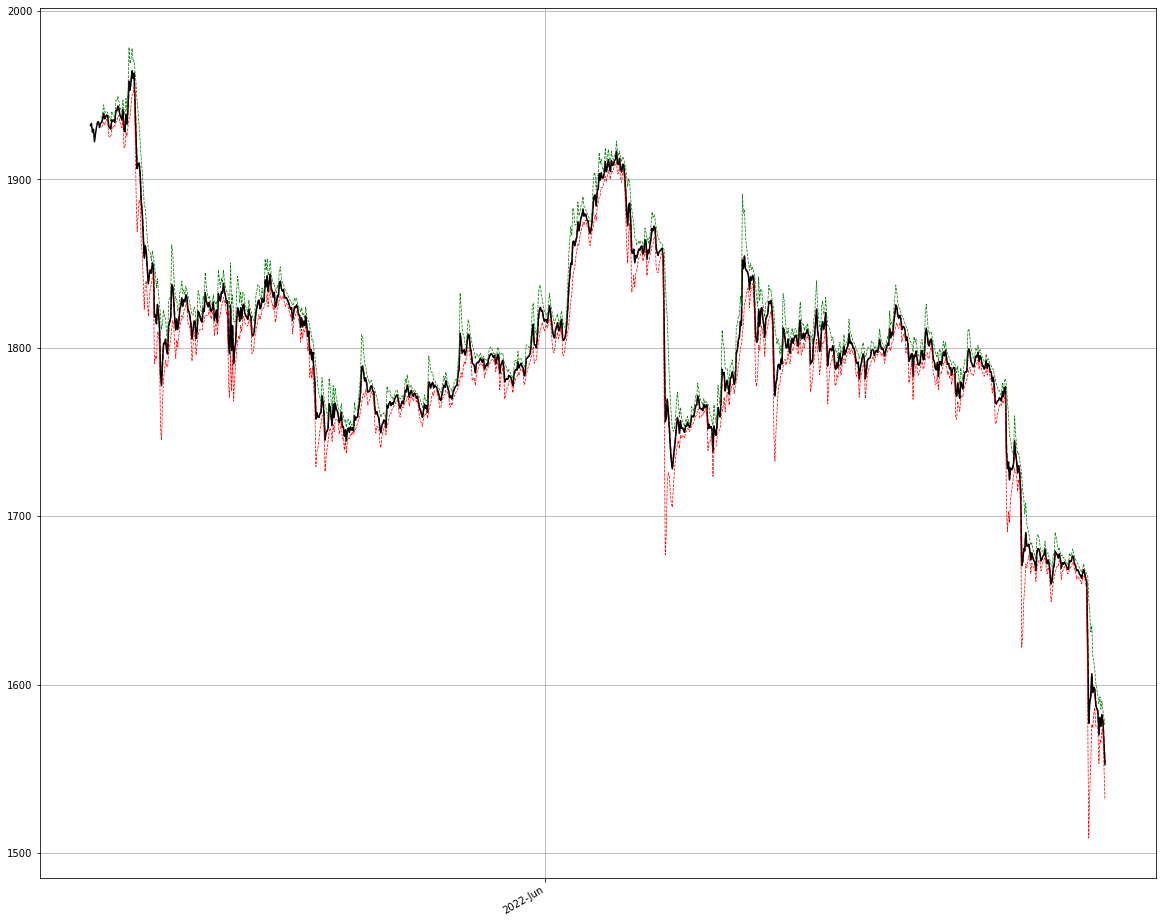

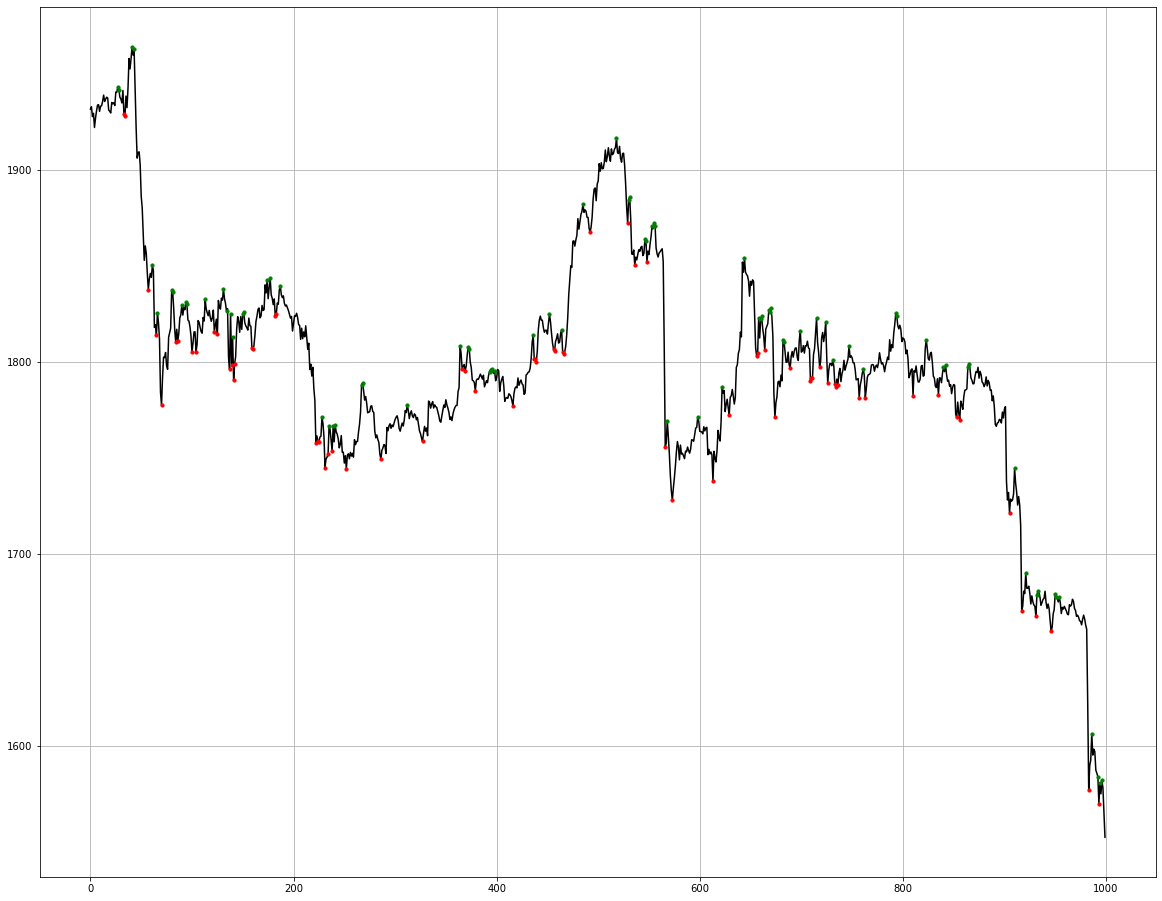

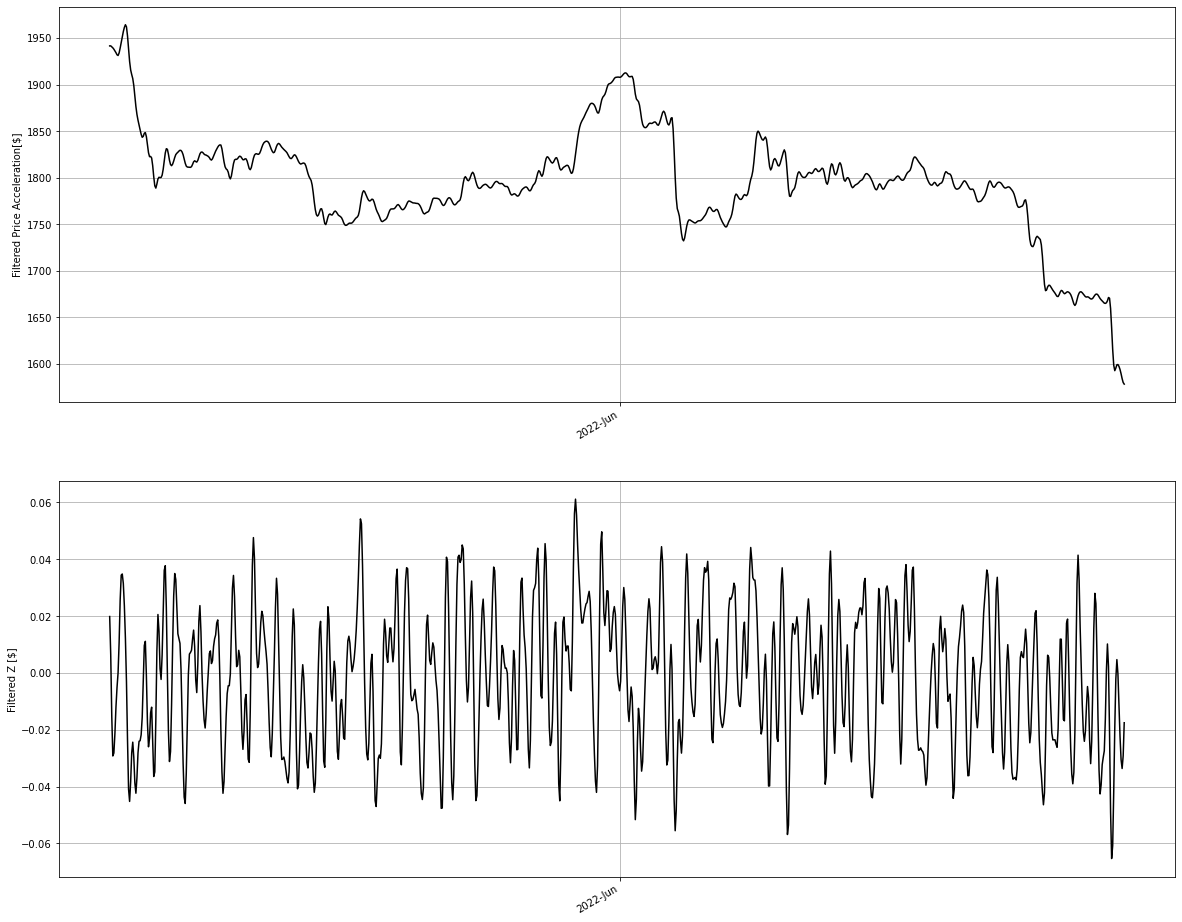

In [18]:

sdb = StaticDatabase(futures_client, PAIR, TIMEFRAME, FROM_DATE, TO_DATE)
sdb.get_historical_klines()
sdb.make_features_and_labels()
(f1, a1), (f2, a2), (f3, axs) = sdb.plot_data()

In [ ]:


# train_data.dropna(inplace=True)
# test_data.dropna(inplace=True)
# test_data.reindex(range(len(test_data))), train_data.reindex(range(len(train_data)))
sdb.train_data

,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,closes_ema,closes_std,closes_z,acc,filtered_acc,filtered_z
26,2.542327,2.480217,2.591825,2.536609,-0.574826,-0.558441,-0.609840,-0.575354,-0.555245,2.537772,-0.417408,0.241611,2.570658,2.560726,0.916045
27,2.541628,2.510790,2.591825,2.584939,-0.537503,-0.516976,-0.639165,-0.580677,-0.560853,2.583519,-0.390439,0.816182,2.587437,2.561767,0.337913
28,2.589828,2.517565,2.591825,2.559384,-0.417061,-0.383868,-0.390649,-0.462401,-0.430734,2.562401,-0.605220,-0.424450,2.470674,2.542398,-0.602037
29,2.564331,2.474485,2.552762,2.491235,-0.574686,-0.558625,-0.571663,-0.622074,-0.607033,2.497140,-0.559673,-1.427585,2.469818,2.524577,-1.198119
30,2.495873,2.422546,2.504844,2.473502,-0.622604,-0.611942,-0.630014,-0.655536,-0.644191,2.476423,-0.603990,-0.554067,2.290565,2.498987,-1.153305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,0.183999,0.187936,0.262250,0.249795,-0.466396,-0.471241,-0.460535,-0.446983,-0.449947,0.246162,-0.358935,0.789019,0.090053,0.233431,0.689801
790,0.244250,0.241960,0.304265,0.221283,-0.490259,-0.495354,-0.507395,-0.440954,-0.443167,0.222590,-0.590790,-0.469844,0.265539,0.289855,1.128419
791,0.217181,0.335937,0.306175,0.350975,-0.090227,-0.080547,-0.029049,0.074415,0.088879,0.342800,-0.134791,1.522500,0.327345,0.373114,1.618596
792,0.345890,0.370679,0.411212,0.432163,-0.080202,-0.068728,-0.078377,-0.048051,-0.035687,0.426487,0.126948,0.965071,0.547858,0.444814,1.665836


In [ ]:
sdb.test_data

,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,closes_ema,closes_std,closes_z,acc,filtered_acc,filtered_z
794,0.527340,0.566798,0.571112,0.507092,0.493696,0.532978,0.620777,0.505586,0.542884,0.508188,0.028018,-0.104932,0.443080,0.475253,0.134211
795,0.502716,0.450412,0.438991,0.421036,0.064962,0.082555,0.087271,-0.145855,-0.135779,0.426385,-0.225844,-1.124121,0.353539,0.451892,-0.564158
796,0.416269,0.377107,0.443331,0.392003,-0.377153,-0.376215,-0.261263,-0.404643,-0.403376,0.394032,-0.378333,-0.586706,0.454722,0.420233,-0.947579
797,0.387105,0.340280,0.455484,0.424861,-0.561526,-0.567410,-0.566811,-0.577678,-0.582103,0.422838,-0.603610,0.667295,0.491018,0.389936,-1.111682
798,0.420111,0.358346,0.417810,0.387831,-0.563041,-0.569295,-0.382946,-0.612370,-0.618115,0.389895,-0.688970,-0.854926,0.240201,0.362651,-1.105331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,-3.437668,-3.458069,-3.386110,-3.438246,-0.254471,-0.330257,-0.070291,-0.284758,-0.360028,-3.440199,0.231225,-0.134976,-3.523765,-3.505246,-0.906642
990,-3.460545,-3.526511,-3.554169,-3.605837,0.803420,0.625027,0.994976,0.568070,0.406182,-3.598610,0.472249,-1.244282,-3.547563,-3.585451,-1.254231
991,-3.628897,-3.628132,-3.631255,-3.633653,1.011481,0.808244,1.024343,0.964430,0.758631,-3.634609,0.277162,-0.378967,-3.369680,-3.676593,-1.388194
992,-3.656665,-3.686498,-3.693062,-3.665120,0.897136,0.703184,1.116829,0.775335,0.587372,-3.666382,0.051695,-0.340545,-4.029850,-3.749224,-1.195881


In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

NameError: name 'training_data' is not defined

In [12]:
sdb.train_seqs

array([None, None, None, None, None, None, None,
       array([[ 2.54232653,  2.48021733,  2.59182504,  2.53660935, -0.57482568,
               -0.55844076, -0.60984002, -0.57535376, -0.55524456,  2.5377716 ,
               -0.41740805,  0.24161076,  2.57065832,  2.56072566,  0.91604493],
              [ 2.54162797,  2.51079034,  2.59182504,  2.58493948, -0.53750257,
               -0.51697566, -0.63916475, -0.58067697, -0.56085284,  2.58351933,
               -0.39043885,  0.81618163,  2.58743652,  2.56176744,  0.33791268],
              [ 2.58982838,  2.51756504,  2.59182504,  2.55938362, -0.41706101,
               -0.38386812, -0.39064936, -0.46240132, -0.4307339 ,  2.56240074,
               -0.60522031, -0.42445007,  2.47067396,  2.54239815, -0.60203668],
              [ 2.56433107,  2.47448489,  2.55276151,  2.49123466, -0.57468644,
               -0.5586248 , -0.57166254, -0.62207403, -0.60703295,  2.49713996,
               -0.5596726 , -1.42758451,  2.46981793,  2.52457699, -

In [19]:
X_train = torch.from_numpy(sdb.train_seqs).float()
y_train = torch.from_numpy(sdb.train_tgt_seqs).float()

# X_test = torch.from_numpy(X_test).float()
# y_test = torch.from_numpy(y_test).float()

In [20]:
X_train.shape

torch.Size([750, 7, 15])

In [ ]:
X_train.shape